# This is the file to run the frozen lake using all three learnings

## Module loading and grid initialiazation

In [24]:
import time
import numpy as np
import random
import pandas as pd
import seaborn
import matplotlib.pylab as plt
import gym
import gym.envs.toy_text.frozen_lake as fl
np.random.seed(1) # set random seed
map_4x4 = fl.generate_random_map(size = 4, p = 0.8)
env_4x4 = fl.FrozenLakeEnv(desc=map_4x4)
map_8x8 = fl.generate_random_map(size = 8, p = 0.8)
env_8x8 = fl.FrozenLakeEnv(desc= map_8x8)
# env_8x8_not_slippery = fl.FrozenLakeEnv(desc=map_8x8,is_slippery=False)
map_25x25 = fl.generate_random_map(size = 25, p = 0.8)
env_25x25= fl.FrozenLakeEnv(desc= map_25x25)
# env_eight = fl.generate_random_map(size = 8, p = 0.8)
# map_twenty_five = fl.generate_random_map(size = 25, p = 0.8)

### function defined

In [ ]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episodes = []
    for i in range(n_epoch):
        initial_state = env.reset()
        episode = 0
        done = False
        total_reward =0;
        # calculate until ep converge
        while not done and episode < n_epoch:
            episode += 1
            action = int(policy[initial_state])
            new_s, r, done, _ = env.step(action)
            total_reward += r
            initial_state = new_s
        rewards.append(total_reward)
        episodes.append(episode)
    
    mean_r = sum(rewards) / len(rewards)
    mean_e = sum(episodes) / len(episodes)
    return mean_r, mean_e

def value_iteration(env, discount=0.8, epsilon=1e-10, record = False):
    # initiate the variables
    start_time = time.time()
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    policies = np.zeros(shape = (1, num_states)) # policies should be as same as states
    values = np.zeros(shape = (1, num_states))
    prev_values = np.copy(values)
    sigma = discount
    iteration = 0
    all_policies = []
    all_rewards = []
    diff = float("inf")
    # do calculation until the max of diff between old and new values < epsilon
    while diff > epsilon:
        iteration += 1
        # go through all states
        for s in range(num_states):
            best_value = float("-inf")
            # check all actions
            for a in range(num_actions):
                # calculate the possible value from all actions
                total_value = 0
                for prob, new_s, r, done in env.P[s][a]:
                    value_new_s = prev_values[0][new_s]
                    cand_value = None
                    if done:
                        cand_value = r
                    else:
                        cand_value = r + sigma * value_new_s
                    total_value += prob * cand_value
                # update the new one if the totaal value is better than the current best one
                if total_value > best_value:
                    # update 
                    best_value = total_value
                    policies[0][s] = a
                    values[0][s] = best_value
        if record:
            new_policy = np.copy(policies)
            all_policies.append(new_policy[0])
            new_reward, new_iteration = test_policy(env, new_policy[0])
            all_rewards.append(new_reward)
        # compare the updated values with prev value list
        diff_list = np.abs(values - prev_values)
        diff = np.max(diff_list)
        prev_values = np.copy(values)

    end_time = time.time()
    runtime = end_time - start_time
    
    if record:
        return policies[0], iteration, runtime, all_policies, all_rewards
    
    return policies[0], iteration, runtime, [], []

def policy_iteration(env, discount=0.8, epsilon=1e-10, record = False):
    start_time = time.time()
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    # generate random polocies
    policies = np.random.randint(num_actions, size = (1, num_states))
    values = np.zeros((1, num_states))
    iterations = 0
    sigma = discount 
    all_policies = []
    all_rewards = []
    converge = False
    while not converge:
        # 1. calculate the values from valuation iterations
        iterations += 1
        reach_threshold = False
        while not reach_threshold:
            diff = 0
            for s in range(num_states):
                val = values[0][s]
                act = policies[0][s]
                total_values = 0
                for prob, new_s, r, done in env.P[s][act]:
                    value_new_s = values[0][new_s]
                    # calculate reward
                    state_val = None
                    if done:
                        state_val = r
                    else:
                        state_val = r + sigma * value_new_s
                    total_values += state_val * prob
                    
                values[0][s] = total_values
                diff = max(diff, np.abs(val - values[0][s]))
        
            if diff < epsilon:
                reach_threshold = True
         
        # 2. compare the old and new policy
        converge = True
        for s in range(num_states):
            prev_action = policies[0][s]
            max_value = float("-inf")
            for a in range(num_actions):
                total_values = 0
                for prob, new_s, r, done in env.P[s][a]:
                    value_new_s = values[0][new_s]
                    state_val = None
                    if done:
                        state_val = r
                    else:
                        state_val = r + sigma * value_new_s
                    total_values += state_val * prob
                if total_values > max_value:
                    max_value = total_values
                    policies[0][s] = a
            
            if prev_action != policies[0][s]:
                converge = False
        if record:
            new_policy = np.copy(policies)
            all_policies.append(new_policy[0])
            new_reward, new_iteration = test_policy(env, new_policy[0])
            all_rewards.append(new_reward)
            
    end_time = time.time()
    runtime = end_time - start_time
    return policies[0], iterations, runtime, all_policies, all_rewards
    

In [25]:
def train_test(env, algo = "Value Iteration", discount = [0.1, 0.2], epsilon = [1e-8, 1e-9], info = False, record = False):
    res = {}
    for disc in discount:
        res[disc] = {} # create a dict inside dic
        for ep in epsilon:
            res[disc][ep] = {}
            policy, iteration, runtime = None, None, None
            if algo == "Value Iteration":
                policy, iteration, runtime, all_policies, all_rewards = value_iteration(env, disc, ep, record)
            elif algo == "Policy Iteration":
                policy, iteration, runtime, all_policies, all_rewards = policy_iteration(env, disc, ep, record)
            mean_reward, mean_iteration = test_policy(env, policy)
            res[disc][ep]["mean_reward"] = mean_reward
            res[disc][ep]["mean_iteration"] = mean_iteration
            res[disc][ep]["policy"] = policy
            res[disc][ep]["iteration"] = iteration
            res[disc][ep]["runtime"] = runtime
            res[disc][ep]["all_policies"] = all_policies
            res[disc][ep]["all_rewards"] = all_rewards
            if info is True:
                print("==== {}: discount - {} and epsilon - {}====".format(algo, disc, ep))
                print("runtime is {} second, {} iterations, the mean rewards:{} and mean iteration: {}".format(runtime, iteration, mean_reward, mean_iteration))
            
    return res

def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy, map_name):
    data = map_discretize(map_name)
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            if i == np_pol[0].size - 1 and j == np_pol[0].size - 1:
                continue
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()


## Value iteration optimization 8x8

In [51]:
discount_list = [0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.9999]
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
vi_8x8_result = train_test(env_8x8, "Value Iteration", discount= discount_list, 
                                        epsilon= epsilon_list, 
                                        info = True, record = False)


==== Value Iteration: discount - 0.1 and epsilon - 0.1====
runtime is 0.029719829559326172 second, 2 iterations, the mean rewards:0.0 and mean iteration: 2.985
==== Value Iteration: discount - 0.1 and epsilon - 0.01====
runtime is 0.0033767223358154297 second, 3 iterations, the mean rewards:0.0 and mean iteration: 3.056
==== Value Iteration: discount - 0.1 and epsilon - 0.0001====
runtime is 0.003263235092163086 second, 4 iterations, the mean rewards:0.0 and mean iteration: 3.011
==== Value Iteration: discount - 0.1 and epsilon - 1e-06====
runtime is 0.0038809776306152344 second, 6 iterations, the mean rewards:0.0 and mean iteration: 3.037
==== Value Iteration: discount - 0.1 and epsilon - 1e-08====
runtime is 0.004868268966674805 second, 8 iterations, the mean rewards:0.0 and mean iteration: 2.975
==== Value Iteration: discount - 0.1 and epsilon - 1e-10====
runtime is 0.00609278678894043 second, 10 iterations, the mean rewards:0.0 and mean iteration: 2.906
==== Value Iteration: discou

==== Value Iteration: discount - 0.95 and epsilon - 0.0001====
runtime is 0.05813002586364746 second, 77 iterations, the mean rewards:0.492 and mean iteration: 63.736
==== Value Iteration: discount - 0.95 and epsilon - 1e-06====
runtime is 0.11137890815734863 second, 135 iterations, the mean rewards:0.515 and mean iteration: 64.64
==== Value Iteration: discount - 0.95 and epsilon - 1e-08====
runtime is 0.14343023300170898 second, 192 iterations, the mean rewards:0.497 and mean iteration: 64.026
==== Value Iteration: discount - 0.95 and epsilon - 1e-10====
runtime is 0.21413087844848633 second, 248 iterations, the mean rewards:0.477 and mean iteration: 66.326
==== Value Iteration: discount - 0.95 and epsilon - 1e-12====
runtime is 0.2178807258605957 second, 304 iterations, the mean rewards:0.482 and mean iteration: 63.884
==== Value Iteration: discount - 0.95 and epsilon - 1e-14====
runtime is 0.2809891700744629 second, 361 iterations, the mean rewards:0.49 and mean iteration: 63.256
==

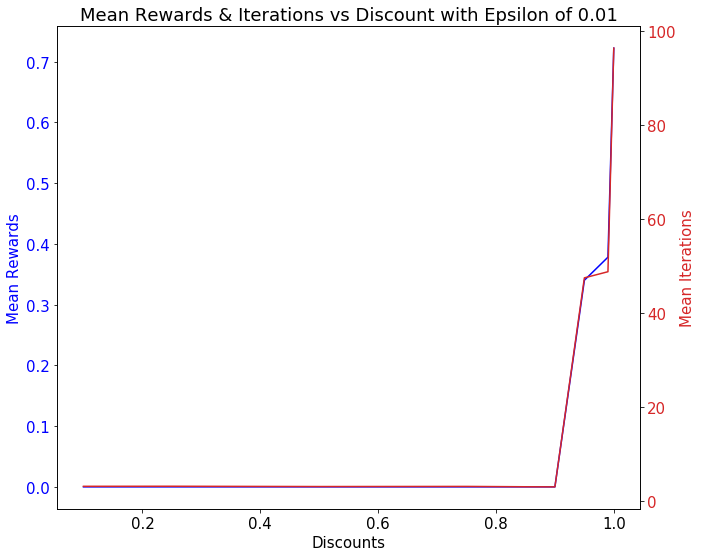

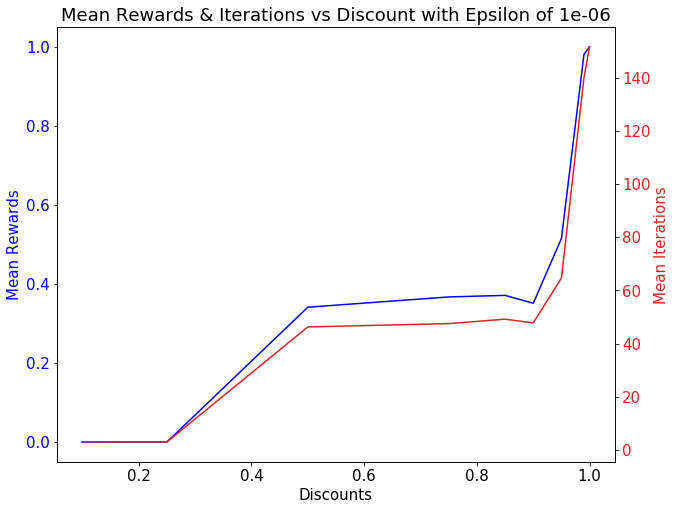

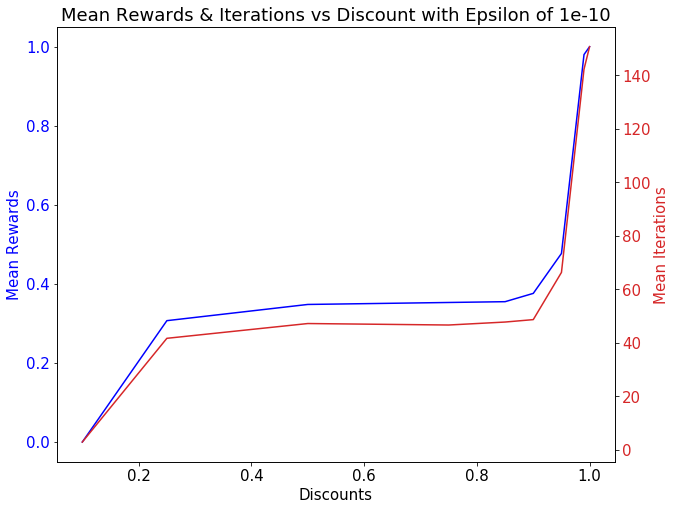

In [52]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 15})

def plot_disc(result, ep_1, ep_2, ep_3, disc_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(disc_list)):
        rewards_1.append(result[disc_list[i]][ep_1]["mean_reward"])
        iterations_1.append(result[disc_list[i]][ep_1]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(disc_list)):
        rewards_2.append(result[disc_list[i]][ep_2]["mean_reward"])
        iterations_2.append(result[disc_list[i]][ep_2]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(disc_list)):
        rewards_3.append(result[disc_list[i]][ep_3]["mean_reward"])
        iterations_3.append(result[disc_list[i]][ep_3]["mean_iteration"])
        
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
    
ep_1 = 1e-2
ep_2 = 1e-6
ep_3 = 1e-10
var = discount_list
plot_disc(vi_8x8_result, ep_1, ep_2, ep_3, var)


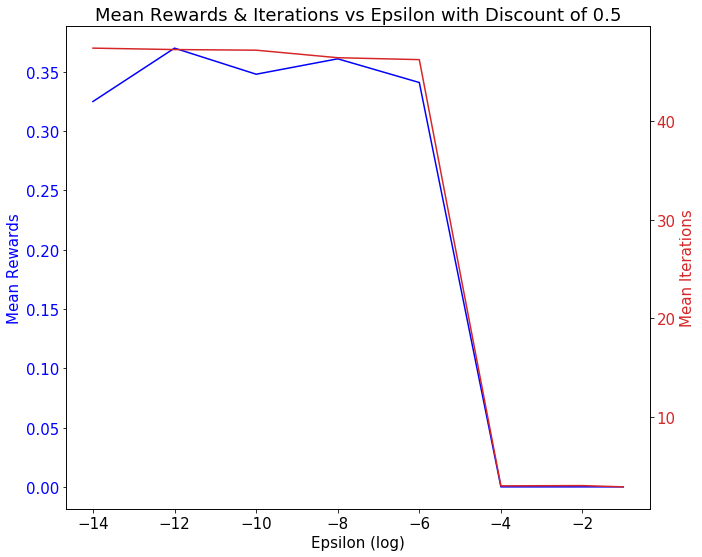

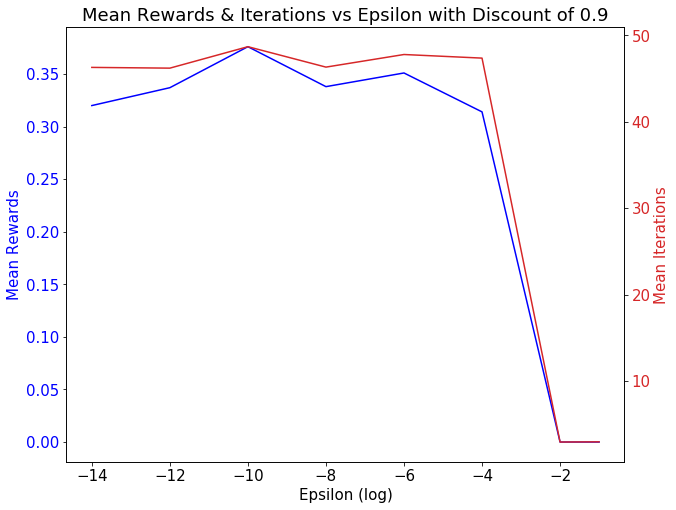

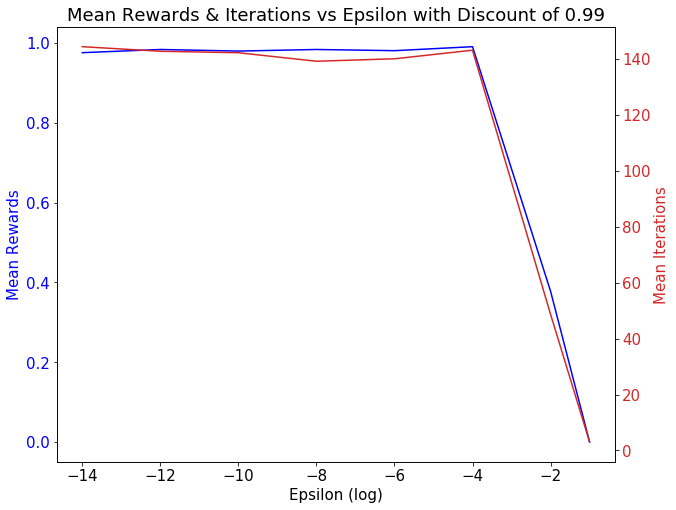

In [53]:
def plot_ep(result, disc_1, disc_2, disc_3, ep_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(ep_list)):
        rewards_1.append(result[disc_1][ep_list[i]]["mean_reward"])
        iterations_1.append(result[disc_1][ep_list[i]]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(ep_list)):
        rewards_2.append(result[disc_2][ep_list[i]]["mean_reward"])
        iterations_2.append(result[disc_2][ep_list[i]]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(ep_list)):
        rewards_3.append(result[disc_3][ep_list[i]]["mean_reward"])
        iterations_3.append(result[disc_3][ep_list[i]]["mean_iteration"])
        
    # conver the epsilon list into log scale
    log_ep_list = [0] * len(ep_list)
    for i in range(len(ep_list)):
        log_ep_list[i] = np.log10(ep_list[i])
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
disc_1 = 0.5
disc_2 = 0.9
disc_3 = 0.99
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
ep_list = epsilon_list
plot_ep(vi_8x8_result, disc_1, disc_2, disc_3, ep_list)


In [54]:
best_discount = 0.99
best_epsilon = 1e-10
vi_8x8_best_result = train_test(env_8x8, "Value Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon], 
                                        info = True, record = True)
all_policy_list_vi_8x8 = vi_8x8_best_result[best_discount][best_epsilon]["all_policies"]
all_reward_list_vi_8x8 = vi_8x8_best_result[best_discount][best_epsilon]["all_rewards"]

==== Value Iteration: discount - 0.99 and epsilon - 1e-10====
runtime is 1092.9786157608032 second, 912 iterations, the mean rewards:0.985 and mean iteration: 138.241


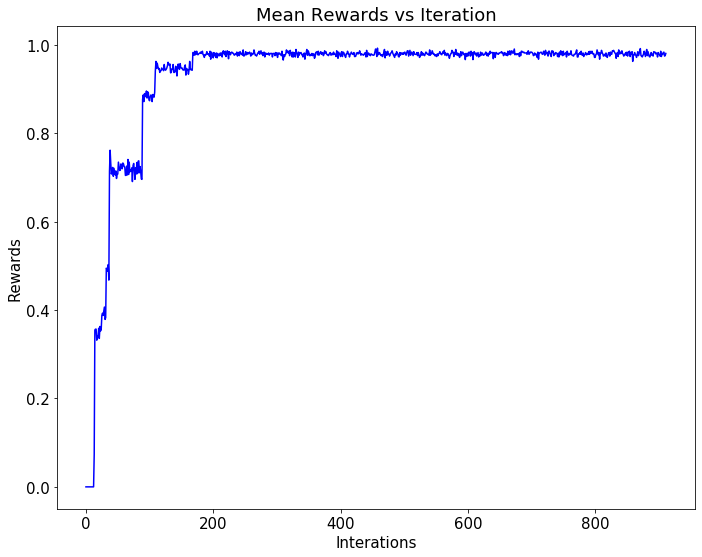

In [118]:
def plot_best(iterations, rewards):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Interations')
    ax1.set_ylabel('Rewards')
    ax1.plot(iterations, rewards, color="blue")
    ax1.set_title("Mean Rewards vs Iteration")

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()
itr = np.arange(0, len(all_reward_list_vi_8x8)).tolist()
plot_best(itr, all_reward_list_vi_8x8)

In [111]:
best_discount_2 = 0.99
best_epsilon_2 = 1e-6
vi_8x8_best_result_2 = train_test(env_8x8, "Value Iteration", discount= [best_discount_2], 
                                        epsilon= [best_epsilon_2], 
                                        info = True, record = True)
all_policy_list_vi_8x8_2 = vi_8x8_best_result_2[best_discount_2][best_epsilon_2]["all_policies"]
all_reward_list_vi_8x8_2 = vi_8x8_best_result_2[best_discount_2][best_epsilon_2]["all_rewards"]

==== Value Iteration: discount - 0.99 and epsilon - 1e-06====
runtime is 1289.735428094864 second, 461 iterations, the mean rewards:0.983 and mean iteration: 145.723


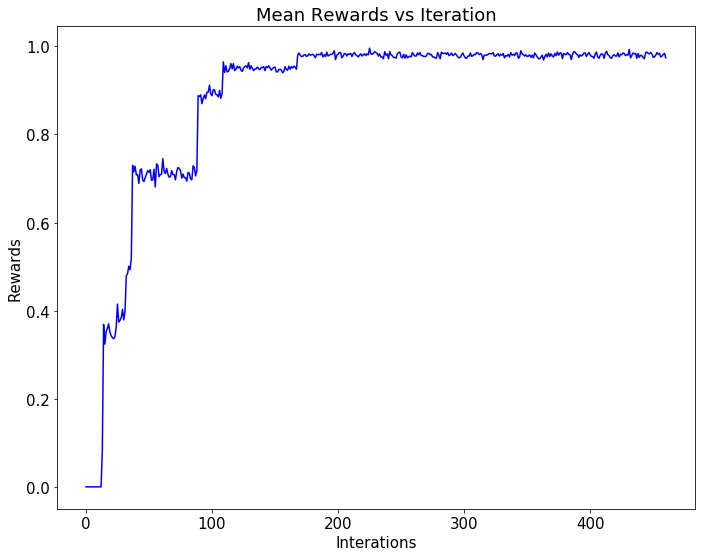

In [121]:
itr = np.arange(0, len(all_reward_list_vi_8x8_2)).tolist()
plot_best(itr, all_reward_list_vi_8x8_2)

In [112]:
best_discount_3 = 0.99
best_epsilon_3 = 1e-2
vi_8x8_best_result_3 = train_test(env_8x8, "Value Iteration", discount= [best_discount_3], 
                                        epsilon= [best_epsilon_3],
                                        info = True, record = True)
all_policy_list_vi_8x8_3 = vi_8x8_best_result_3[best_discount_3][best_epsilon_3]["all_policies"]
all_reward_list_vi_8x8_3 = vi_8x8_best_result_3[best_discount_3][best_epsilon_3]["all_rewards"]

==== Value Iteration: discount - 0.99 and epsilon - 0.01====
runtime is 14.841094732284546 second, 29 iterations, the mean rewards:0.403 and mean iteration: 51.874


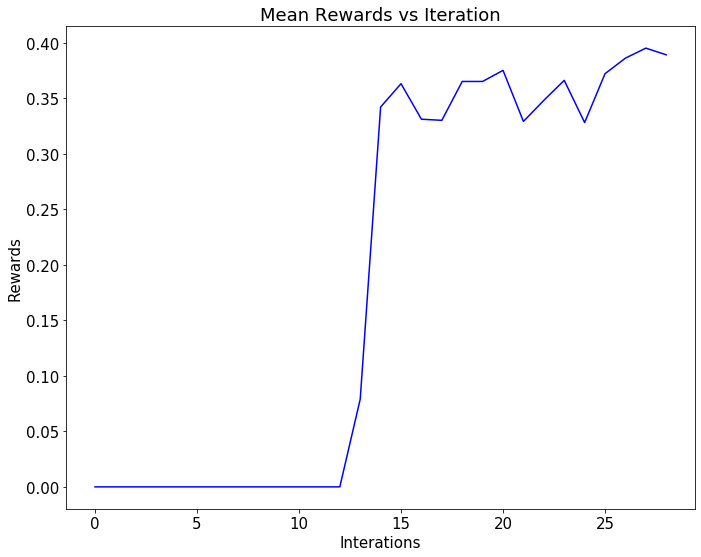

In [122]:
itr = np.arange(0, len(all_reward_list_vi_8x8_3)).tolist()
plot_best(itr, all_reward_list_vi_8x8_3)

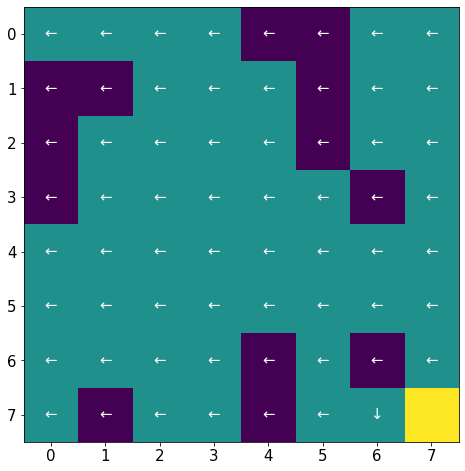

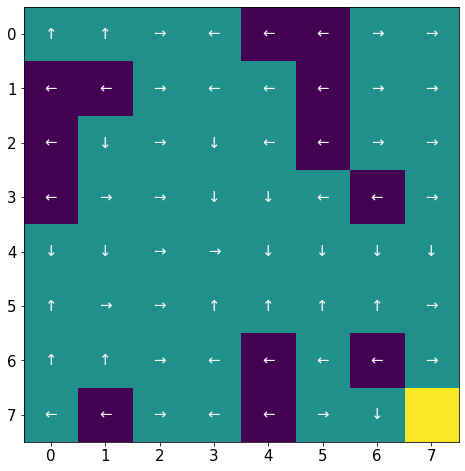

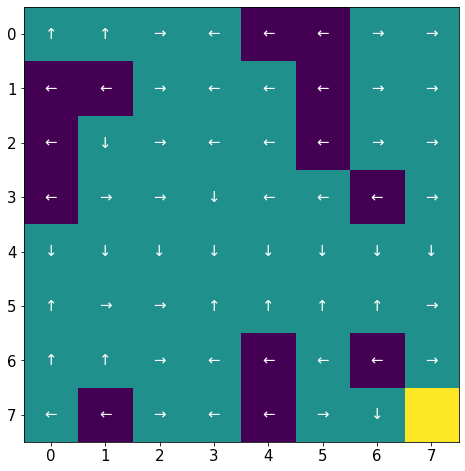

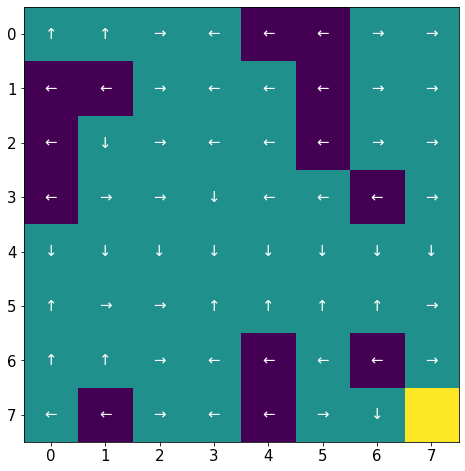

In [56]:
see_policy(8, all_policy_list_vi_8x8[0], map_8x8)
see_policy(8, all_policy_list_vi_8x8[50], map_8x8)
see_policy(8, all_policy_list_vi_8x8[180], map_8x8)
see_policy(8, all_policy_list_vi_8x8[200], map_8x8)

## Value iteration optimization 30x30

In [35]:
map_30x30 = fl.generate_random_map(size = 30, p = 0.85)
env_30x30 = fl.FrozenLakeEnv(desc= map_30x30)
discount_list = [0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.9999]
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
vi_30x30_result = train_test(env_30x30, "Value Iteration", discount= discount_list, 
                                        epsilon= epsilon_list, 
                                        info = True, record = False)


==== Value Iteration: discount - 0.1 and epsilon - 0.1====
runtime is 0.02529311180114746 second, 2 iterations, the mean rewards:0.0 and mean iteration: 191.293
==== Value Iteration: discount - 0.1 and epsilon - 0.01====
runtime is 0.031147003173828125 second, 3 iterations, the mean rewards:0.0 and mean iteration: 198.282
==== Value Iteration: discount - 0.1 and epsilon - 0.0001====
runtime is 0.053788185119628906 second, 5 iterations, the mean rewards:0.0 and mean iteration: 201.178
==== Value Iteration: discount - 0.1 and epsilon - 1e-06====
runtime is 0.05710196495056152 second, 6 iterations, the mean rewards:0.0 and mean iteration: 196.233
==== Value Iteration: discount - 0.1 and epsilon - 1e-08====
runtime is 0.09205102920532227 second, 8 iterations, the mean rewards:0.0 and mean iteration: 191.867
==== Value Iteration: discount - 0.1 and epsilon - 1e-10====
runtime is 0.09601306915283203 second, 10 iterations, the mean rewards:0.0 and mean iteration: 197.601
==== Value Iteration:

==== Value Iteration: discount - 0.95 and epsilon - 0.0001====
runtime is 1.0062570571899414 second, 92 iterations, the mean rewards:0.556 and mean iteration: 179.02
==== Value Iteration: discount - 0.95 and epsilon - 1e-06====
runtime is 1.8704278469085693 second, 172 iterations, the mean rewards:0.623 and mean iteration: 188.004
==== Value Iteration: discount - 0.95 and epsilon - 1e-08====
runtime is 2.7555150985717773 second, 252 iterations, the mean rewards:0.62 and mean iteration: 196.367
==== Value Iteration: discount - 0.95 and epsilon - 1e-10====
runtime is 3.4333651065826416 second, 323 iterations, the mean rewards:0.626 and mean iteration: 193.001
==== Value Iteration: discount - 0.95 and epsilon - 1e-12====
runtime is 4.216776132583618 second, 388 iterations, the mean rewards:0.62 and mean iteration: 191.592
==== Value Iteration: discount - 0.95 and epsilon - 1e-14====
runtime is 4.768939018249512 second, 450 iterations, the mean rewards:0.61 and mean iteration: 190.071
====

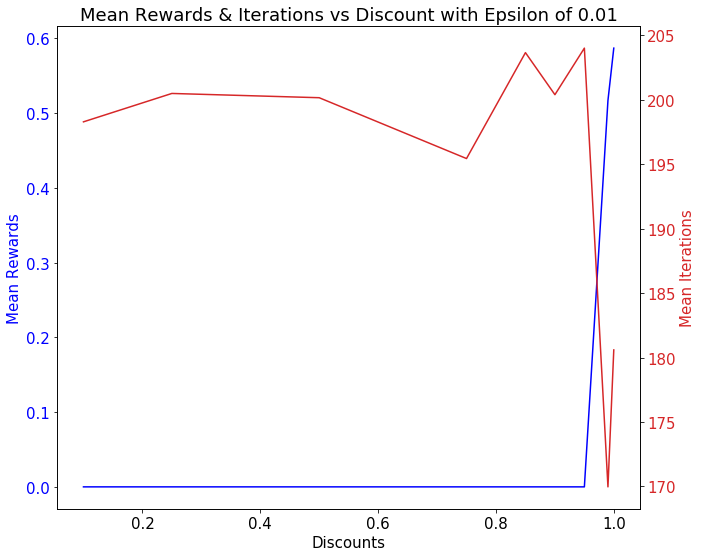

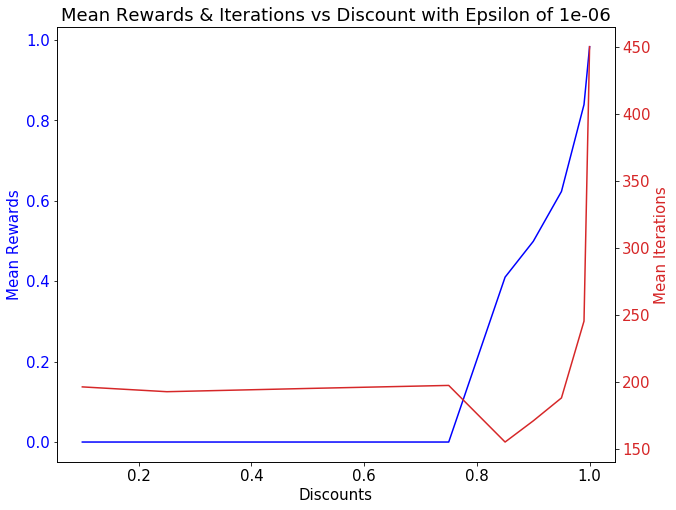

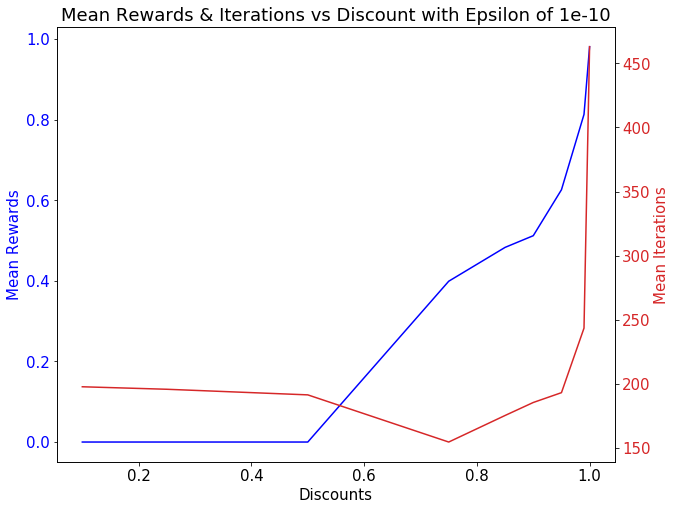

In [36]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 15})

def plot_disc(result, ep_1, ep_2, ep_3, disc_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(disc_list)):
        rewards_1.append(result[disc_list[i]][ep_1]["mean_reward"])
        iterations_1.append(result[disc_list[i]][ep_1]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(disc_list)):
        rewards_2.append(result[disc_list[i]][ep_2]["mean_reward"])
        iterations_2.append(result[disc_list[i]][ep_2]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(disc_list)):
        rewards_3.append(result[disc_list[i]][ep_3]["mean_reward"])
        iterations_3.append(result[disc_list[i]][ep_3]["mean_iteration"])
        
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
    
ep_1 = 1e-2
ep_2 = 1e-6
ep_3 = 1e-10
var = discount_list
plot_disc(vi_30x30_result, ep_1, ep_2, ep_3, var)


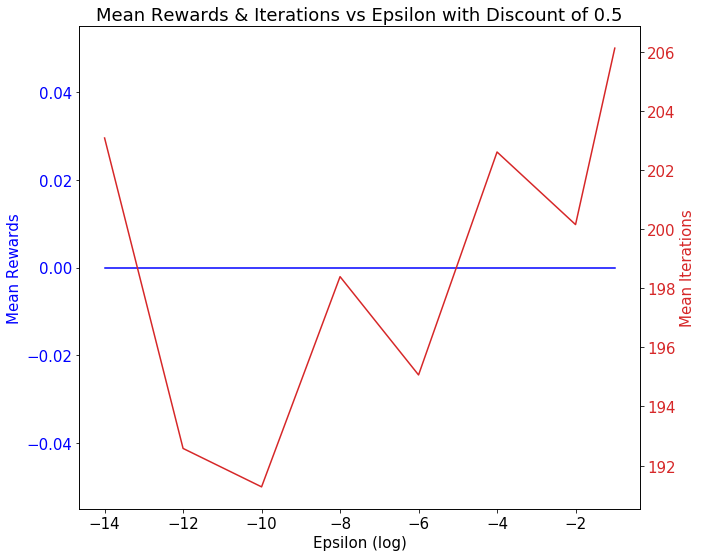

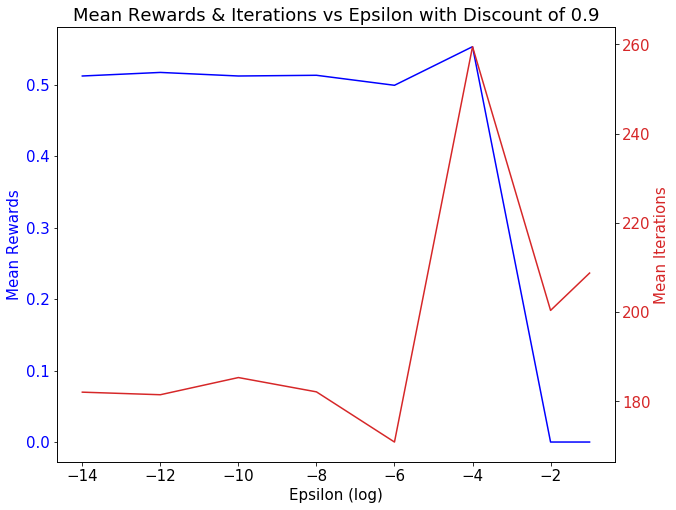

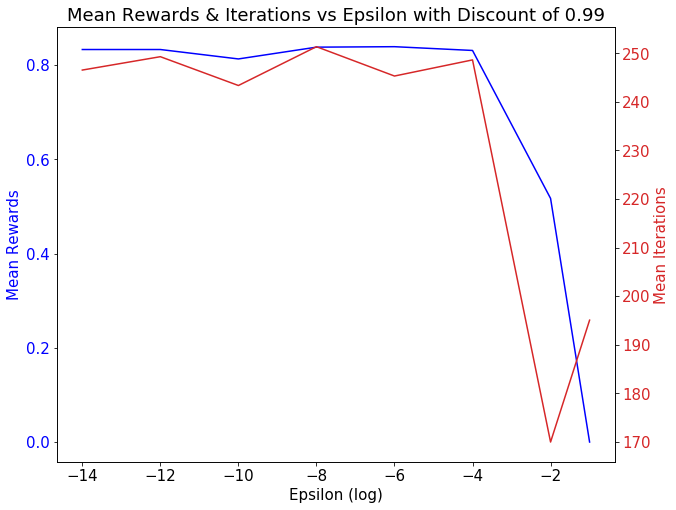

In [37]:
def plot_ep(result, disc_1, disc_2, disc_3, ep_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(ep_list)):
        rewards_1.append(result[disc_1][ep_list[i]]["mean_reward"])
        iterations_1.append(result[disc_1][ep_list[i]]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(ep_list)):
        rewards_2.append(result[disc_2][ep_list[i]]["mean_reward"])
        iterations_2.append(result[disc_2][ep_list[i]]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(ep_list)):
        rewards_3.append(result[disc_3][ep_list[i]]["mean_reward"])
        iterations_3.append(result[disc_3][ep_list[i]]["mean_iteration"])
        
    # conver the epsilon list into log scale
    log_ep_list = [0] * len(ep_list)
    for i in range(len(ep_list)):
        log_ep_list[i] = np.log10(ep_list[i])
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
disc_1 = 0.5
disc_2 = 0.9
disc_3 = 0.99
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
ep_list = epsilon_list
plot_ep(vi_30x30_result, disc_1, disc_2, disc_3, ep_list)


In [38]:
best_discount = 0.9999
best_epsilon = 1e-4
vi_30x30_best_result = train_test(env_30x30, "Value Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon], 
                                        info = True, record = True)
all_policy_list_vi_30x30 = vi_30x30_best_result[best_discount][best_epsilon]["all_policies"]
all_reward_list_vi_30x30 = vi_30x30_best_result[best_discount][best_epsilon]["all_rewards"]

==== Value Iteration: discount - 0.9999 and epsilon - 0.0001====
runtime is 2464.883763074875 second, 743 iterations, the mean rewards:0.974 and mean iteration: 443.611


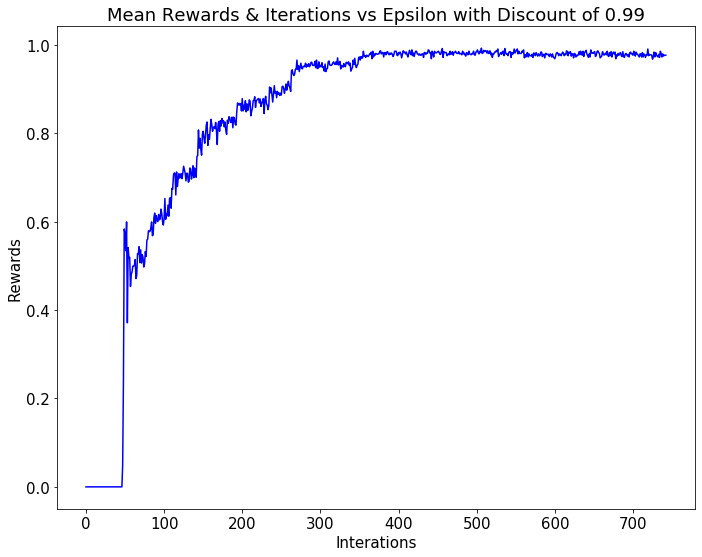

In [39]:
def plot_best(iterations, rewards):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Interations')
    ax1.set_ylabel('Rewards')
    ax1.plot(iterations, rewards, color="blue")
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()
itr = np.arange(0, len(all_reward_list_vi_30x30)).tolist()
plot_best(itr, all_reward_list_vi_30x30)

In [41]:
vi_30x30_best_result[best_discount][best_epsilon]["runtime"]

2464.883763074875

In [142]:
best_discount = 0.9999
best_epsilon_2 = 1e-8
vi_30x30_best_result_2 = train_test(env_30x30, "Value Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon_2], 
                                        info = True, record = True)
all_policy_list_vi_30x30_2 = vi_30x30_best_result_2[best_discount][best_epsilon_2]["all_policies"]
all_reward_list_vi_30x30_2 = vi_30x30_best_result_2[best_discount][best_epsilon_2]["all_rewards"]

print("2 completed")


best_discount = 0.9999
best_epsilon_3 = 1e-12
vi_30x30_best_result_3 = train_test(env_30x30, "Value Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon_3], 
                                        info = True, record = True)
all_policy_list_vi_30x30_3 = vi_30x30_best_result_3[best_discount][best_epsilon_3]["all_policies"]
all_reward_list_vi_30x30_3 = vi_30x30_best_result_3[best_discount][best_epsilon_3]["all_rewards"]

==== Value Iteration: discount - 0.9999 and epsilon - 1e-08====
runtime is 27728.413912057877 second, 3240 iterations, the mean rewards:0.864 and mean iteration: 612.632
2 completed
==== Value Iteration: discount - 0.9999 and epsilon - 1e-12====
runtime is 32077.090157032013 second, 5508 iterations, the mean rewards:0.855 and mean iteration: 609.262


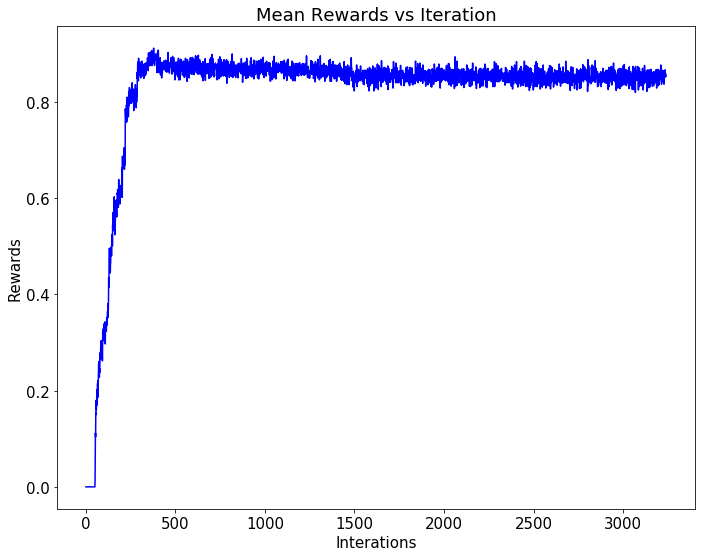

In [143]:
itr = np.arange(0, len(all_reward_list_vi_30x30_2)).tolist()
plot_best(itr, all_reward_list_vi_30x30_2)

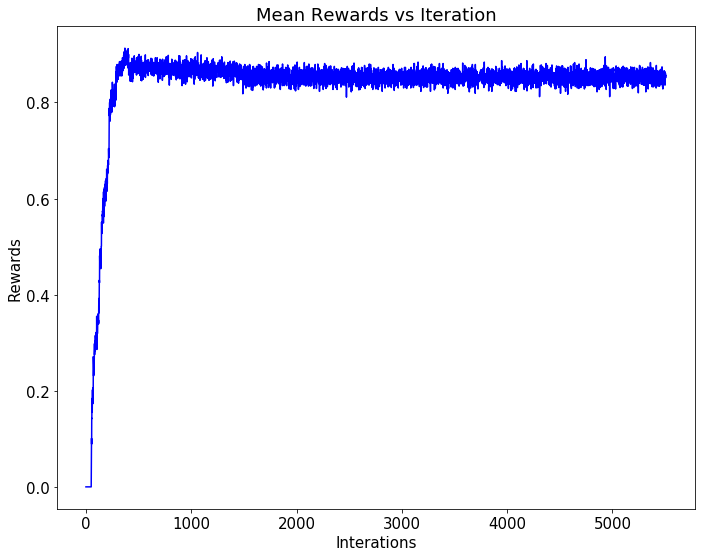

In [144]:
itr = np.arange(0, len(all_reward_list_vi_30x30_3)).tolist()
plot_best(itr, all_reward_list_vi_30x30_3)

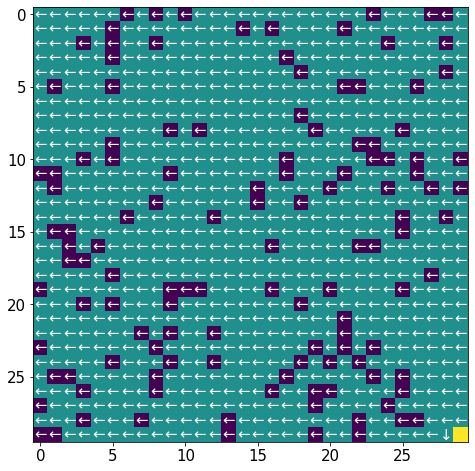

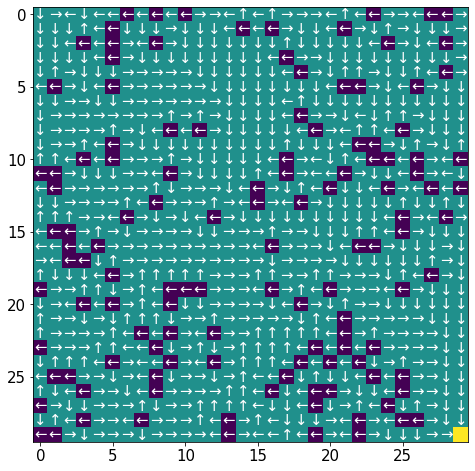

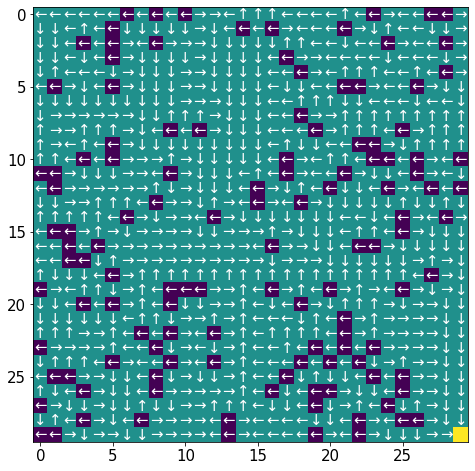

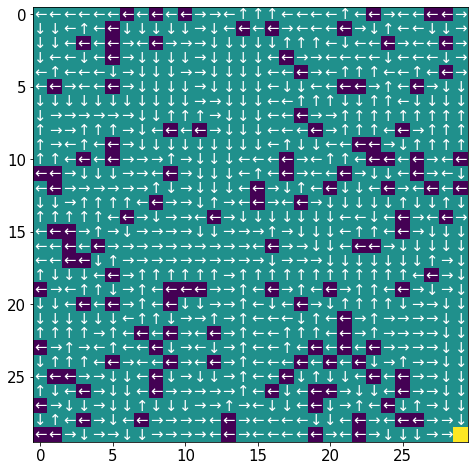

In [42]:
see_policy(30, all_policy_list_vi_30x30[0], map_30x30)
see_policy(30, all_policy_list_vi_30x30[100], map_30x30)
see_policy(30, all_policy_list_vi_30x30[400], map_30x30)
see_policy(30, all_policy_list_vi_30x30[700], map_30x30)

## Policy iteration optimization 8x8

In [57]:
# np.random.seed(1) # set random seed
# map_4x4 = fl.generate_random_map(size = 4, p = 0.8)
# env_4x4 = fl.FrozenLakeEnv(desc=map_4x4)
discount_list = [0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.9999]
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
pi_8x8_result = train_test(env_8x8, "Policy Iteration", discount= discount_list, 
                                        epsilon= epsilon_list, 
                                        info = True, record = False)

==== Policy Iteration: discount - 0.1 and epsilon - 0.1====
runtime is 0.032113075256347656 second, 15 iterations, the mean rewards:0.29 and mean iteration: 39.483
==== Policy Iteration: discount - 0.1 and epsilon - 0.01====
runtime is 0.014477014541625977 second, 13 iterations, the mean rewards:0.269 and mean iteration: 40.216
==== Policy Iteration: discount - 0.1 and epsilon - 0.0001====
runtime is 0.014390945434570312 second, 10 iterations, the mean rewards:0.27 and mean iteration: 40.261
==== Policy Iteration: discount - 0.1 and epsilon - 1e-06====
runtime is 0.01448512077331543 second, 9 iterations, the mean rewards:0.277 and mean iteration: 40.554
==== Policy Iteration: discount - 0.1 and epsilon - 1e-08====
runtime is 0.016943931579589844 second, 9 iterations, the mean rewards:0.307 and mean iteration: 44.644
==== Policy Iteration: discount - 0.1 and epsilon - 1e-10====
runtime is 0.011450052261352539 second, 5 iterations, the mean rewards:0.308 and mean iteration: 44.483
==== P

==== Policy Iteration: discount - 0.95 and epsilon - 0.0001====
runtime is 0.09916067123413086 second, 10 iterations, the mean rewards:0.5 and mean iteration: 66.589
==== Policy Iteration: discount - 0.95 and epsilon - 1e-06====
runtime is 0.07716774940490723 second, 4 iterations, the mean rewards:0.491 and mean iteration: 64.182
==== Policy Iteration: discount - 0.95 and epsilon - 1e-08====
runtime is 0.1512010097503662 second, 4 iterations, the mean rewards:0.512 and mean iteration: 64.825
==== Policy Iteration: discount - 0.95 and epsilon - 1e-10====
runtime is 0.2380971908569336 second, 4 iterations, the mean rewards:0.471 and mean iteration: 64.898
==== Policy Iteration: discount - 0.95 and epsilon - 1e-12====
runtime is 0.27995800971984863 second, 4 iterations, the mean rewards:0.476 and mean iteration: 64.408
==== Policy Iteration: discount - 0.95 and epsilon - 1e-14====
runtime is 0.6032679080963135 second, 11 iterations, the mean rewards:0.485 and mean iteration: 63.301
==== P

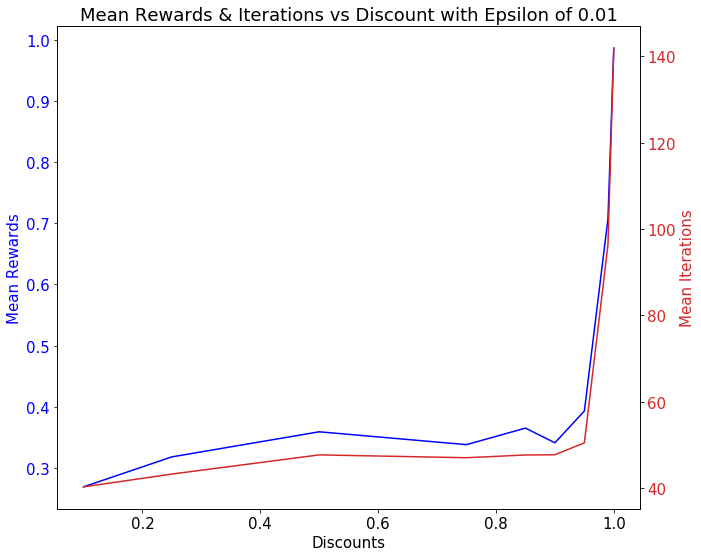

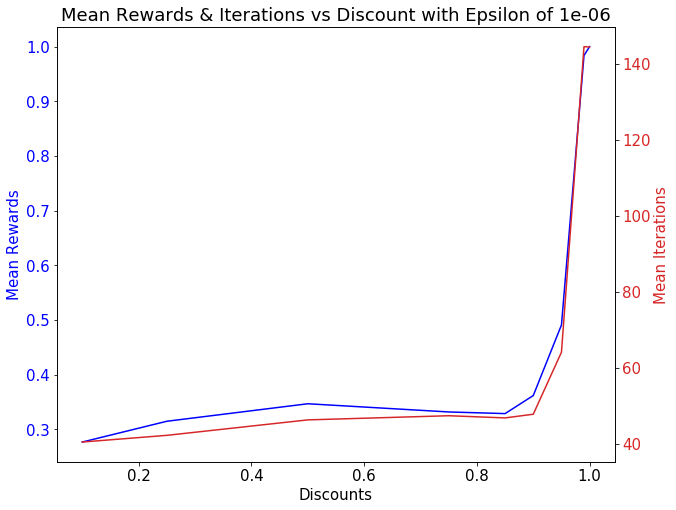

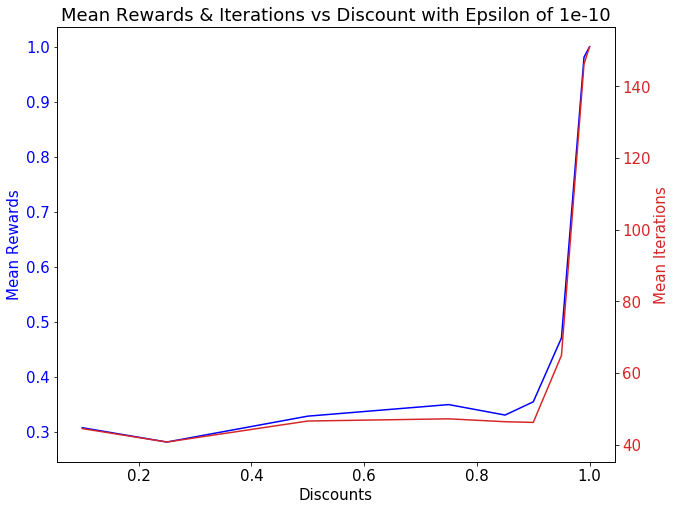

In [58]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 15})

def plot_disc(result, ep_1, ep_2, ep_3, disc_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(disc_list)):
        rewards_1.append(result[disc_list[i]][ep_1]["mean_reward"])
        iterations_1.append(result[disc_list[i]][ep_1]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(disc_list)):
        rewards_2.append(result[disc_list[i]][ep_2]["mean_reward"])
        iterations_2.append(result[disc_list[i]][ep_2]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(disc_list)):
        rewards_3.append(result[disc_list[i]][ep_3]["mean_reward"])
        iterations_3.append(result[disc_list[i]][ep_3]["mean_iteration"])
        
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
    
ep_1 = 1e-2
ep_2 = 1e-6
ep_3 = 1e-10
var = discount_list
plot_disc(pi_8x8_result, ep_1, ep_2, ep_3, var)


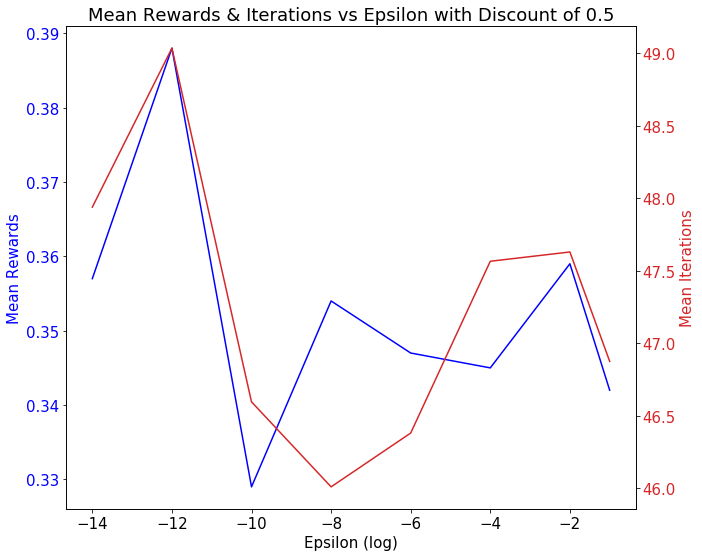

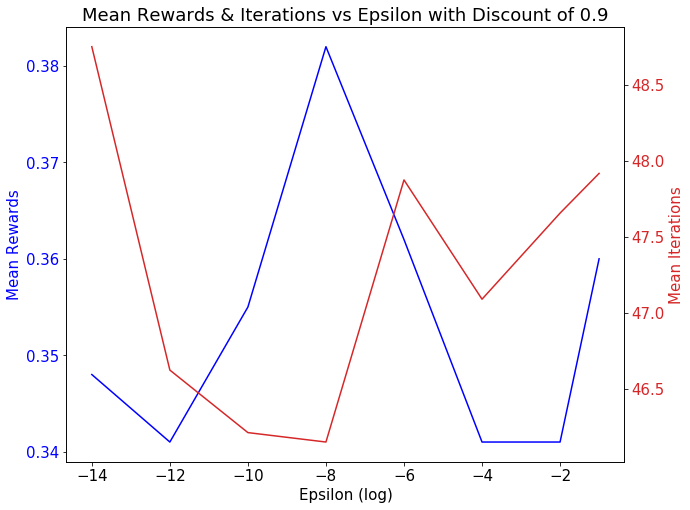

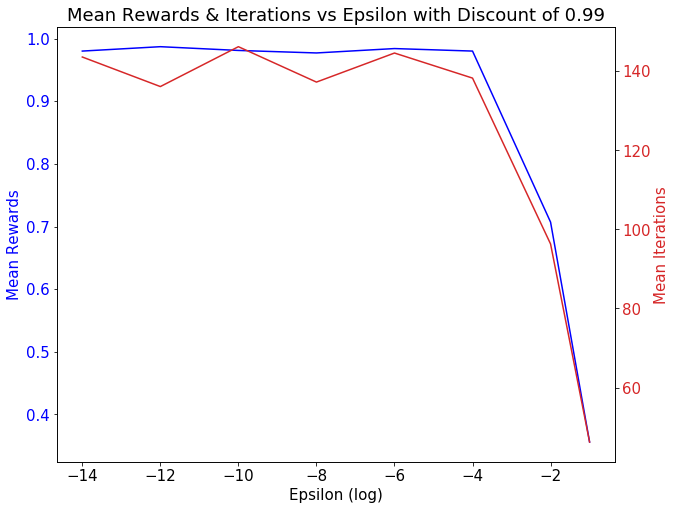

In [59]:
def plot_ep(result, disc_1, disc_2, disc_3, ep_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(ep_list)):
        rewards_1.append(result[disc_1][ep_list[i]]["mean_reward"])
        iterations_1.append(result[disc_1][ep_list[i]]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(ep_list)):
        rewards_2.append(result[disc_2][ep_list[i]]["mean_reward"])
        iterations_2.append(result[disc_2][ep_list[i]]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(ep_list)):
        rewards_3.append(result[disc_3][ep_list[i]]["mean_reward"])
        iterations_3.append(result[disc_3][ep_list[i]]["mean_iteration"])
        
    # conver the epsilon list into log scale
    log_ep_list = [0] * len(ep_list)
    for i in range(len(ep_list)):
        log_ep_list[i] = np.log10(ep_list[i])
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
disc_1 = 0.5
disc_2 = 0.9
disc_3 = 0.99
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
ep_list = epsilon_list
plot_ep(pi_8x8_result, disc_1, disc_2, disc_3, ep_list)


In [60]:
best_discount = 0.99
best_epsilon = 1e-10
pi_8x8_best_result = train_test(env_8x8, "Policy Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon], 
                                        info = True, record = True)
pi_8x8_all_policy_list = pi_8x8_best_result[best_discount][best_epsilon]["all_policies"]
pi_8x8_all_reward_list = pi_8x8_best_result[best_discount][best_epsilon]["all_rewards"]

==== Policy Iteration: discount - 0.99 and epsilon - 1e-10====
runtime is 6.592997789382935 second, 8 iterations, the mean rewards:0.979 and mean iteration: 140.484


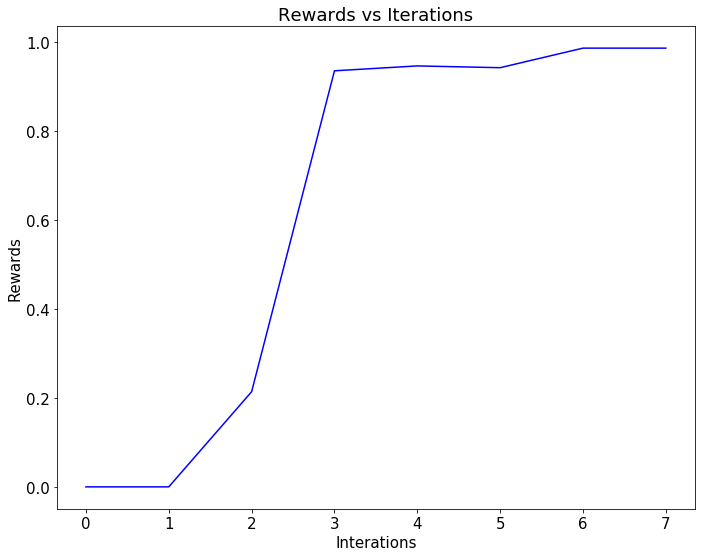

In [62]:
def plot_best(iterations, rewards):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Interations')
    ax1.set_ylabel('Rewards')
    ax1.plot(iterations, rewards, color="blue")
    ax1.set_title("Rewards vs Iterations")

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()
itr = np.arange(0, len(pi_8x8_all_reward_list)).tolist()
plot_best(itr, pi_8x8_all_reward_list)

In [123]:
best_discount_2 = 0.99
best_epsilon_2 = 1e-6
pi_8x8_best_result_2 = train_test(env_8x8, "Policy Iteration", discount= [best_discount_2], 
                                        epsilon= [best_epsilon_2], 
                                        info = True, record = True)
pi_8x8_all_policy_list_2 = pi_8x8_best_result_2[best_discount_2][best_epsilon_2]["all_policies"]
pi_8x8_all_reward_list_2 = pi_8x8_best_result_2[best_discount_2][best_epsilon_2]["all_rewards"]

==== Policy Iteration: discount - 0.99 and epsilon - 1e-06====
runtime is 8.236478805541992 second, 4 iterations, the mean rewards:0.981 and mean iteration: 149.076


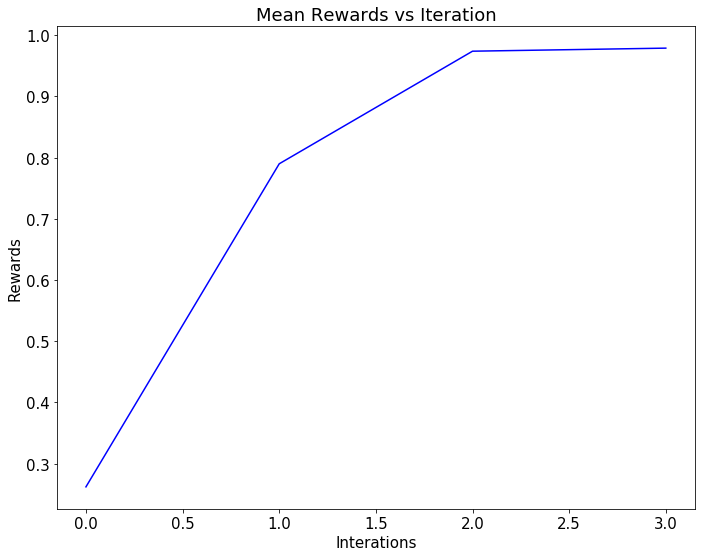

In [125]:
itr = np.arange(0, len(pi_8x8_all_reward_list_2)).tolist()
plot_best(itr, pi_8x8_all_reward_list_2)

In [124]:
best_discount_3 = 0.99
best_epsilon_3 = 1e-2
pi_8x8_best_result_3 = train_test(env_8x8, "Policy Iteration", discount= [best_discount_3], 
                                        epsilon= [best_epsilon_3], 
                                        info = True, record = True)
pi_8x8_all_policy_list_3 = pi_8x8_best_result_3[best_discount_3][best_epsilon_3]["all_policies"]
pi_8x8_all_reward_list_3 = pi_8x8_best_result_3[best_discount_3][best_epsilon_3]["all_rewards"]

==== Policy Iteration: discount - 0.99 and epsilon - 0.01====
runtime is 5.165792942047119 second, 9 iterations, the mean rewards:0.698 and mean iteration: 91.855


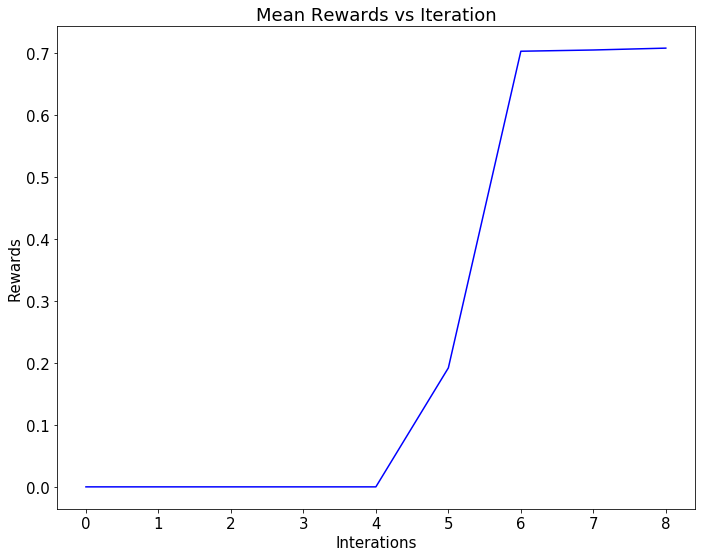

In [126]:
itr = np.arange(0, len(pi_8x8_all_reward_list_3)).tolist()
plot_best(itr, pi_8x8_all_reward_list_3)

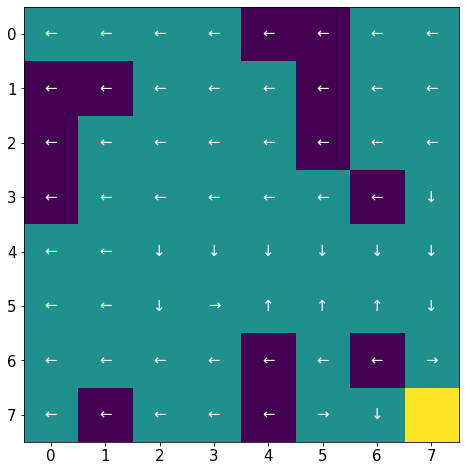

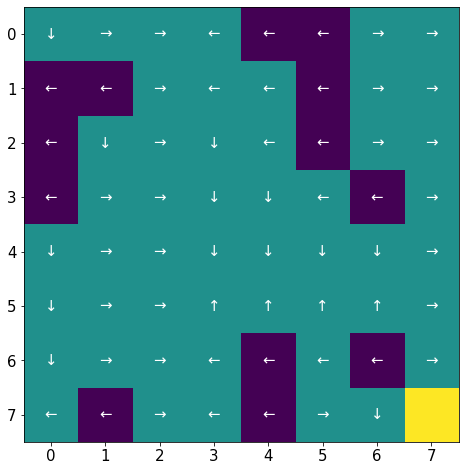

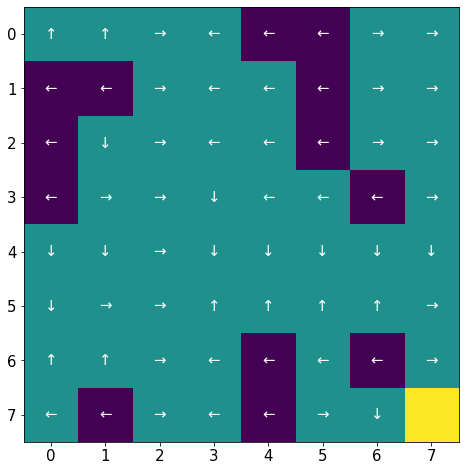

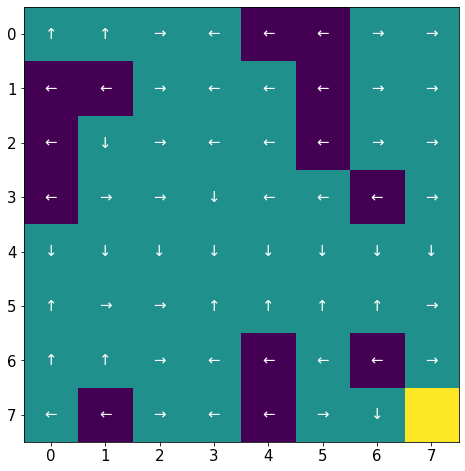

In [83]:
see_policy(8, pi_8x8_all_policy_list[0], map_8x8)
see_policy(8, pi_8x8_all_policy_list[2], map_8x8)
see_policy(8, pi_8x8_all_policy_list[4], map_8x8)
see_policy(8, pi_8x8_all_policy_list[6], map_8x8)

## Policy iteration optimization 30x30

In [70]:
map_30x30 = fl.generate_random_map(size = 30, p = 0.87)
env_30x30 = fl.FrozenLakeEnv(desc= map_30x30)
discount_list = [0.1, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 0.9999]
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
pi_30x30_result = train_test(env_30x30, "Policy Iteration", discount= discount_list, 
                                        epsilon= epsilon_list, 
                                        info = True, record = False)

==== Policy Iteration: discount - 0.1 and epsilon - 0.1====
runtime is 1.0318362712860107 second, 57 iterations, the mean rewards:0.062 and mean iteration: 121.276
==== Policy Iteration: discount - 0.1 and epsilon - 0.01====
runtime is 1.064899206161499 second, 55 iterations, the mean rewards:0.063 and mean iteration: 124.942
==== Policy Iteration: discount - 0.1 and epsilon - 0.0001====
runtime is 1.0410029888153076 second, 55 iterations, the mean rewards:0.075 and mean iteration: 127.48
==== Policy Iteration: discount - 0.1 and epsilon - 1e-06====
runtime is 0.9994409084320068 second, 51 iterations, the mean rewards:0.077 and mean iteration: 125.241
==== Policy Iteration: discount - 0.1 and epsilon - 1e-08====
runtime is 0.8900768756866455 second, 44 iterations, the mean rewards:0.059 and mean iteration: 125.947
==== Policy Iteration: discount - 0.1 and epsilon - 1e-10====
runtime is 0.9217820167541504 second, 43 iterations, the mean rewards:0.07 and mean iteration: 125.332
==== Poli

==== Policy Iteration: discount - 0.95 and epsilon - 0.0001====
runtime is 2.4526560306549072 second, 42 iterations, the mean rewards:0.262 and mean iteration: 186.025
==== Policy Iteration: discount - 0.95 and epsilon - 1e-06====
runtime is 2.5385990142822266 second, 10 iterations, the mean rewards:0.304 and mean iteration: 199.807
==== Policy Iteration: discount - 0.95 and epsilon - 1e-08====
runtime is 3.03707218170166 second, 6 iterations, the mean rewards:0.273 and mean iteration: 193.082
==== Policy Iteration: discount - 0.95 and epsilon - 1e-10====
runtime is 19.504583835601807 second, 36 iterations, the mean rewards:0.264 and mean iteration: 190.86
==== Policy Iteration: discount - 0.95 and epsilon - 1e-12====
runtime is 8.785115718841553 second, 9 iterations, the mean rewards:0.276 and mean iteration: 191.999
==== Policy Iteration: discount - 0.95 and epsilon - 1e-14====
runtime is 33.47934007644653 second, 35 iterations, the mean rewards:0.281 and mean iteration: 194.513
====

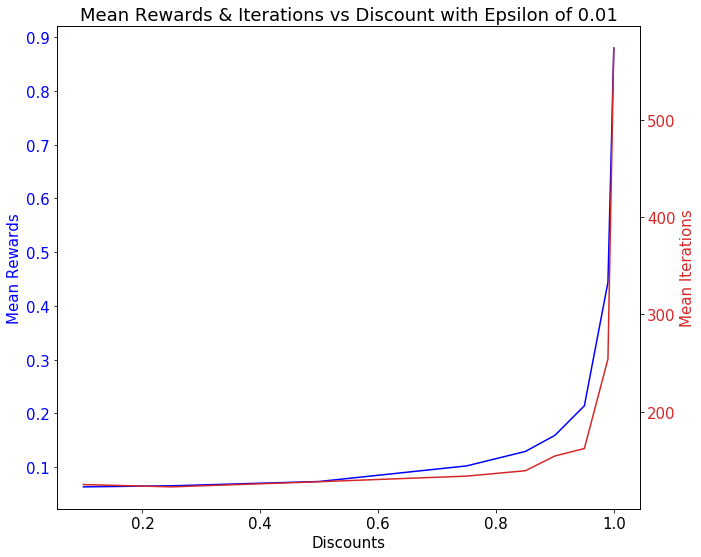

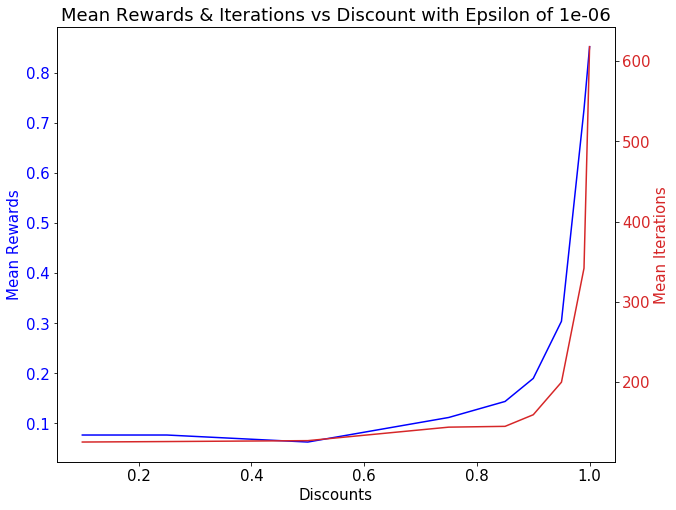

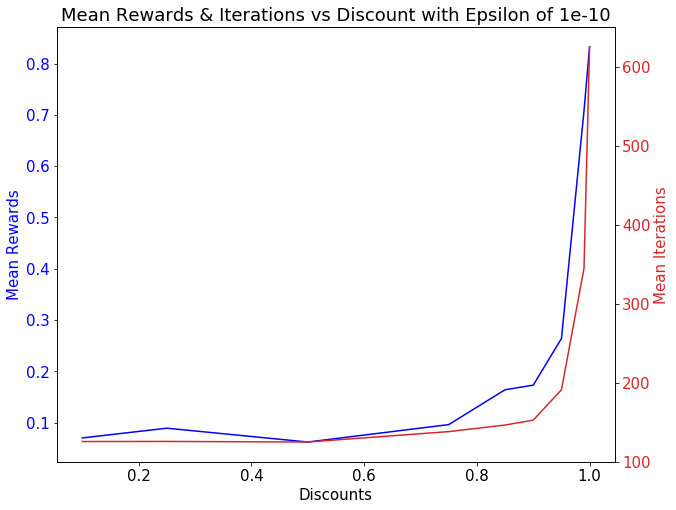

In [71]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
matplotlib.rcParams.update({'font.size': 15})

def plot_disc(result, ep_1, ep_2, ep_3, disc_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(disc_list)):
        rewards_1.append(result[disc_list[i]][ep_1]["mean_reward"])
        iterations_1.append(result[disc_list[i]][ep_1]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(disc_list)):
        rewards_2.append(result[disc_list[i]][ep_2]["mean_reward"])
        iterations_2.append(result[disc_list[i]][ep_2]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(disc_list)):
        rewards_3.append(result[disc_list[i]][ep_3]["mean_reward"])
        iterations_3.append(result[disc_list[i]][ep_3]["mean_iteration"])
        
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Discounts')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(disc_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(disc_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Discount with Epsilon of {}".format(ep_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
    
ep_1 = 1e-2
ep_2 = 1e-6
ep_3 = 1e-10
var = discount_list
plot_disc(pi_30x30_result, ep_1, ep_2, ep_3, var)


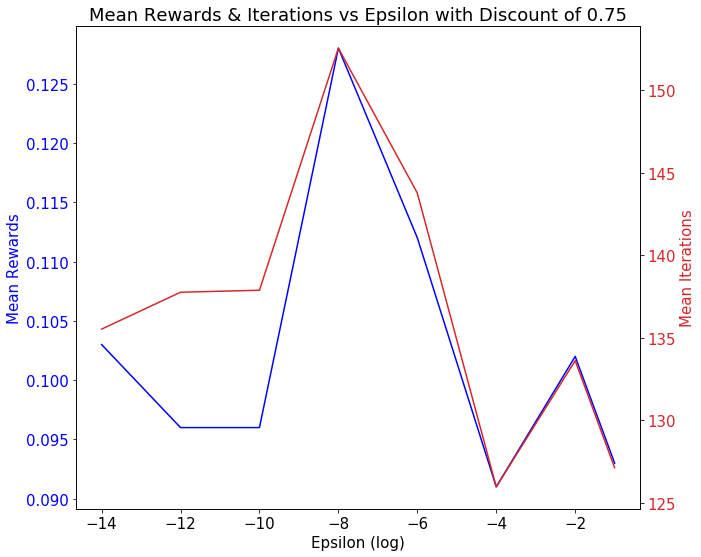

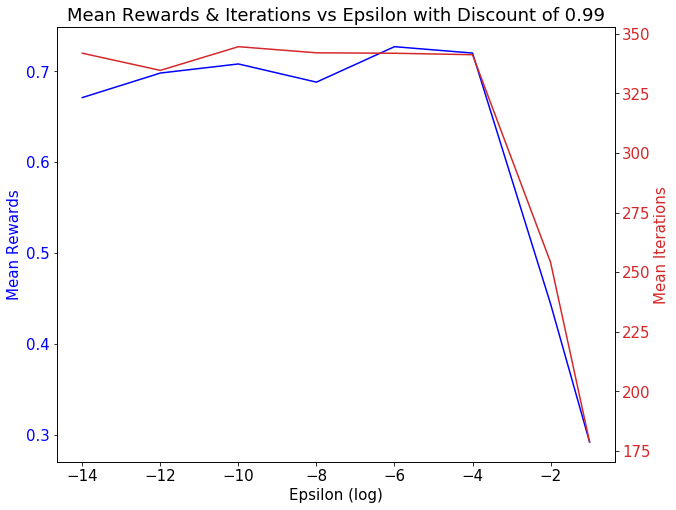

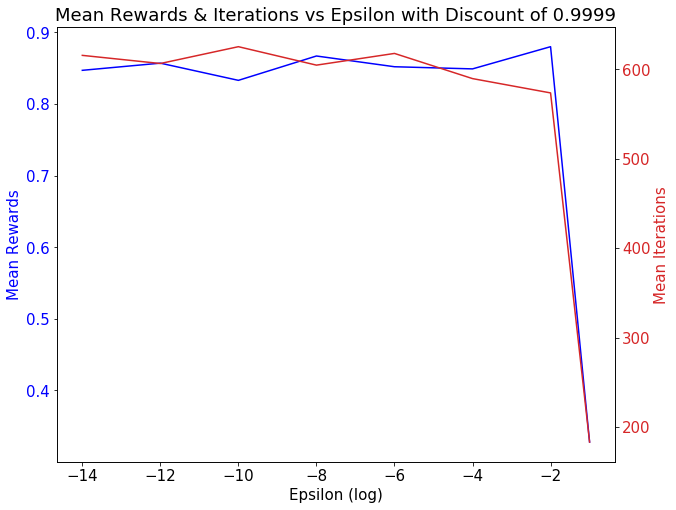

In [75]:
def plot_ep(result, disc_1, disc_2, disc_3, ep_list):
    rewards_1 = []
    iterations_1 = []
    for i in range(len(ep_list)):
        rewards_1.append(result[disc_1][ep_list[i]]["mean_reward"])
        iterations_1.append(result[disc_1][ep_list[i]]["mean_iteration"])
    rewards_2 = []
    iterations_2 = []
    for i in range(len(ep_list)):
        rewards_2.append(result[disc_2][ep_list[i]]["mean_reward"])
        iterations_2.append(result[disc_2][ep_list[i]]["mean_iteration"])
    rewards_3 = []
    iterations_3 = []
    for i in range(len(ep_list)):
        rewards_3.append(result[disc_3][ep_list[i]]["mean_reward"])
        iterations_3.append(result[disc_3][ep_list[i]]["mean_iteration"])
        
    # conver the epsilon list into log scale
    log_ep_list = [0] * len(ep_list)
    for i in range(len(ep_list)):
        log_ep_list[i] = np.log10(ep_list[i])
    # ========== plotting
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_1, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_1, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_1))

    fig_2 = plt.figure()
    ax1 = fig_2.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_2, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_2))
    
    fig_3 = plt.figure()
    ax1 = fig_3.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Epsilon (log)')
    ax1.set_ylabel('Mean Rewards', color="blue")
    ln1 = ax1.plot(log_ep_list, rewards_3, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Mean Iterations', color=color)  # we already handled the x-label with ax1
    ln2 = ax2.plot(log_ep_list, iterations_3, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.set_title("Mean Rewards & Iterations vs Epsilon with Discount of {}".format(disc_3))

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

    
disc_1 = 0.75
disc_2 = 0.99
disc_3 = 0.9999
epsilon_list = [1e-1, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12, 1e-14]
ep_list = epsilon_list
plot_ep(pi_30x30_result, disc_1, disc_2, disc_3, ep_list)


In [80]:
best_discount = 0.9999
best_epsilon = 1e-12
pi_30x30_best_result = train_test(env_30x30, "Policy Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon], 
                                        info = True, record = True)
pi_30x30_all_policy_list = pi_30x30_best_result[best_discount][best_epsilon]["all_policies"]
pi_30x30_all_reward_list = pi_30x30_best_result[best_discount][best_epsilon]["all_rewards"]

==== Policy Iteration: discount - 0.9999 and epsilon - 1e-12====
runtime is 151.70391607284546 second, 7 iterations, the mean rewards:0.846 and mean iteration: 612.744


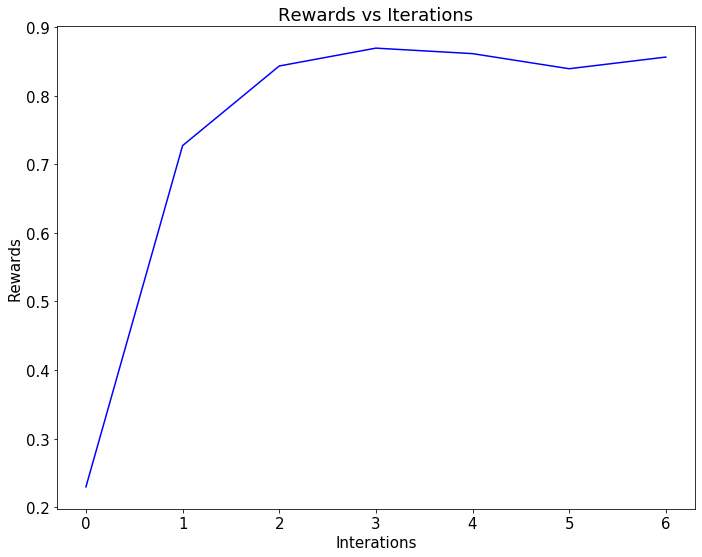

In [81]:
def plot_best(iterations, rewards):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Interations')
    ax1.set_ylabel('Rewards')
    ax1.plot(iterations, rewards, color="blue")
    ax1.set_title("Rewards vs Iterations")

    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()
itr = np.arange(0, len(pi_30x30_all_reward_list)).tolist()
plot_best(itr, pi_30x30_all_reward_list)

In [139]:
best_discount = 0.9999
best_epsilon_2 = 1e-8
pi_30x30_best_result_2 = train_test(env_30x30, "Policy Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon_2], 
                                        info = True, record = True)
pi_30x30_all_policy_list_2 = pi_30x30_best_result_2[best_discount][best_epsilon_2]["all_policies"]
pi_30x30_all_reward_list_2 = pi_30x30_best_result_2[best_discount][best_epsilon_2]["all_rewards"]

best_discount = 0.9999
best_epsilon_3 = 1e-4
pi_30x30_best_result_3 = train_test(env_30x30, "Policy Iteration", discount= [best_discount], 
                                        epsilon= [best_epsilon_3], 
                                        info = True, record = True)
pi_30x30_all_policy_list_3 = pi_30x30_best_result_3[best_discount][best_epsilon_3]["all_policies"]
pi_30x30_all_reward_list_3 = pi_30x30_best_result_3[best_discount][best_epsilon_3]["all_rewards"]

==== Policy Iteration: discount - 0.9999 and epsilon - 1e-08====
runtime is 532.810626745224 second, 36 iterations, the mean rewards:0.854 and mean iteration: 616.642
==== Policy Iteration: discount - 0.9999 and epsilon - 0.0001====
runtime is 182.5312581062317 second, 36 iterations, the mean rewards:0.837 and mean iteration: 621.572


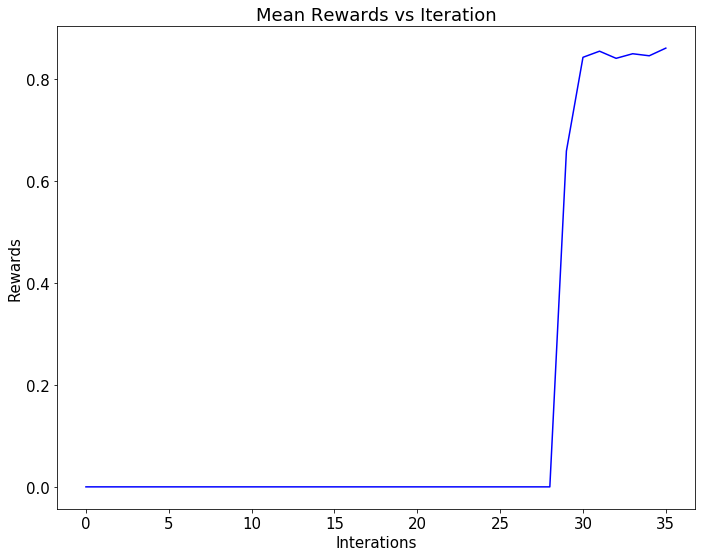

In [140]:
itr = np.arange(0, len(pi_30x30_all_reward_list_2)).tolist()
plot_best(itr, pi_30x30_all_reward_list_2)

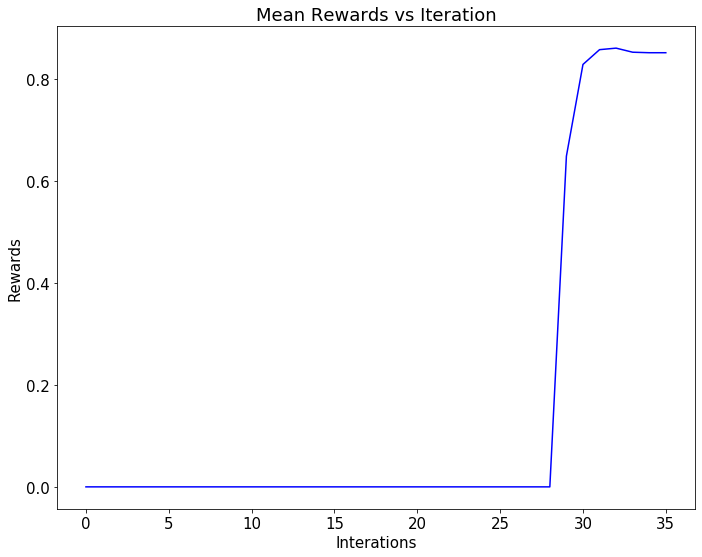

In [141]:
itr = np.arange(0, len(pi_30x30_all_reward_list_3)).tolist()
plot_best(itr, pi_30x30_all_reward_list_3)

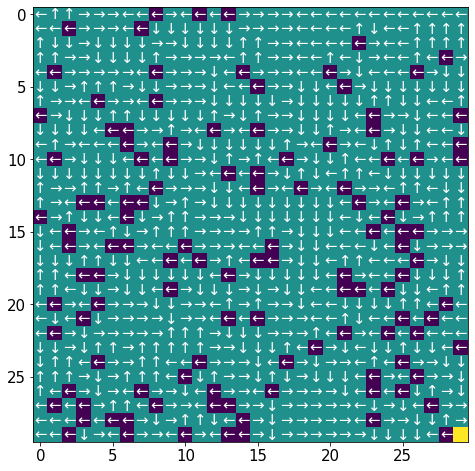

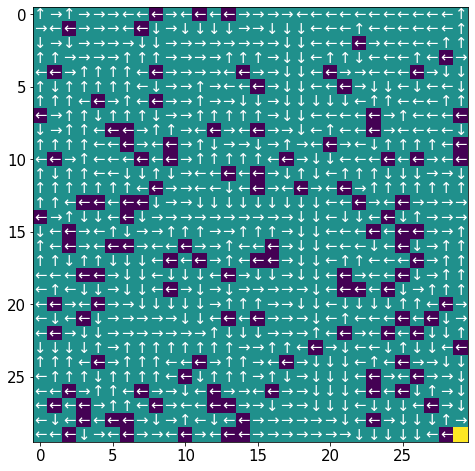

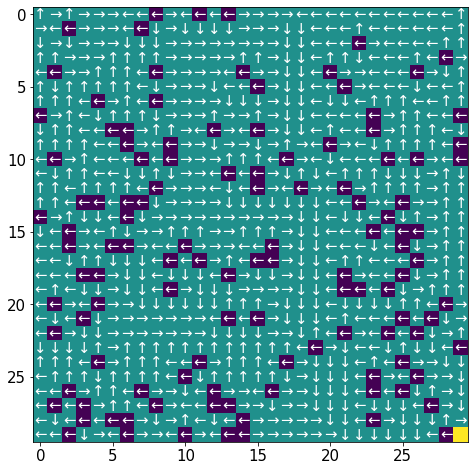

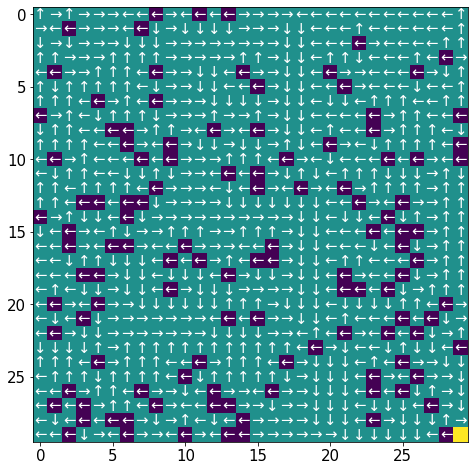

In [84]:
see_policy(30, pi_30x30_all_policy_list[0], map_30x30)
see_policy(30, pi_30x30_all_policy_list[2], map_30x30)
see_policy(30, pi_30x30_all_policy_list[4], map_30x30)
see_policy(30, pi_30x30_all_policy_list[6], map_30x30)

## Q learning

In [85]:
def q_learning(env, discount=0.9, total_episodes=1e5, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start_time = time.time()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    
    qtable = np.zeros((number_of_states, number_of_actions))
    learning_rate = alpha
    gamma = discount

    # exploration parameter
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./total_episodes
    
    rewards = []
    for episode in range(int(total_episodes)):
        # reset the environment
        state = env.reset()
        step = 0
        done = False
        total_reward = 0
        while True:

            # choose an action a in the corrent world state
            exp_exp_tradeoff = random.uniform(0,1)

            # if greater than epsilon --> exploit
            if exp_exp_tradeoff > epsilon:
                b = qtable[state, :]
                action = np.random.choice(np.where(b == b.max())[0])
#                 action = np.argmax(qtable[state, :])
            # else choose exploration
            else:
                action = env.action_space.sample()

            # take action (a) and observe the outcome state (s') and reward (r)    
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + learning_rate*(reward + gamma*np.max(qtable[new_state, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + learning_rate*(reward - qtable[state,action])

            # change state
            state = new_state

            # is it Done
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * episode, min_epsilon) 
    #     print (epsilon)
    
    end_time = time.time()
    runtime = end_time - start_time
    print("Solved in: {} episodes and {} seconds".format(total_episodes, runtime))
    return np.argmax(qtable, axis=1), total_episodes, runtime, qtable, rewards

def train_and_test_q_learning(env, discount=[0.9], total_episodes=[1e5], alphas=[0.1], decay_rates=[0.01], mute=False):
    
    min_epsilon = 0.01
    
    q_dict = {}
    for dis in discount:
        q_dict[dis] = {}
        for eps in total_episodes:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    
                    # run q_learning
                    q_policy, q_solve_iter, q_solve_time, q_table, rewards = q_learning(env, dis, eps, alpha, dr, min_epsilon)
                    q_mean_reward, q_mean_iteration = test_policy(env, q_policy)
                    q_dict[dis][eps][alpha][dr]["mean_reward"] = q_mean_reward
                    q_dict[dis][eps][alpha][dr]["mean_iteration"] = q_mean_iteration
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_solve_iter
                    q_dict[dis][eps][alpha][dr]["runtime"] = q_solve_time
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("gamma: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
                        print("Iteration: {} time: {}".format(q_solve_iter, q_solve_time))
                        print("Mean reward: {} - mean eps: {}".format(q_mean_reward, q_mean_iteration))
    return q_dict

def dict_to_df(the_dict):
    the_df = pd.DataFrame(columns=["Discount Rate", "Training Episodes", "Learning Rate", 
                                   "Decay Rate", "Reward", "Runtime"])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for dr in the_dict[dis][eps][lr]:
                    rew = the_dict[dis][eps][lr][dr]["mean_reward"]
                    time_spent = the_dict[dis][eps][lr][dr]["runtime"]
                    dic = {"Discount Rate": dis, "Training Episodes": eps, "Learning Rate":lr, 
                           "Decay Rate":dr, "Reward": rew, "Runtime": time_spent}
                    the_df = the_df.append(dic, ignore_index=True)
    return the_df

import numpy as np

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# 8x8

In [88]:
episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]

q_dict_8x8 = train_and_test_q_learning(env_8x8, discount=[0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 1.6775479316711426 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 1.6775479316711426
Mean reward: 0.016 - mean eps: 25.193
Solved in: 10000.0 episodes and 1.099726915359497 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 1.099726915359497
Mean reward: 0.002 - mean eps: 25.573
Solved in: 10000.0 episodes and 1.4011008739471436 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 1.4011008739471436
Mean reward: 0.0 - mean eps: 2.924
Solved in: 10000.0 episodes and 1.0842909812927246 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 1.0842909812927246
Mean reward: 0.032 - mean eps: 37.711
Solved in: 100000.0 episodes and 414.7412211894989 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 414.7412211894989
Mean reward: 0.983 - mean eps: 204.457
Solved in: 100000.0 episodes and 89.

/Users/hung-hsilin/miniconda3/envs/CS6476/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


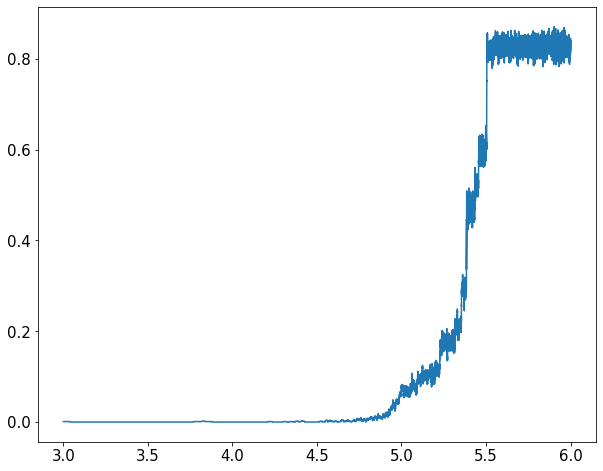

In [95]:
import seaborn as sns
r1 = q_dict_8x8[0.9999][1e6][0.01][1e-5]["rewards"]
run = 1000
rew_running = running_mean(r1, run)
indices = [i+run for i in list(range(len(rew_running)))]
sns.lineplot(np.log10(indices), rew_running)

/Users/hung-hsilin/miniconda3/envs/CS6476/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


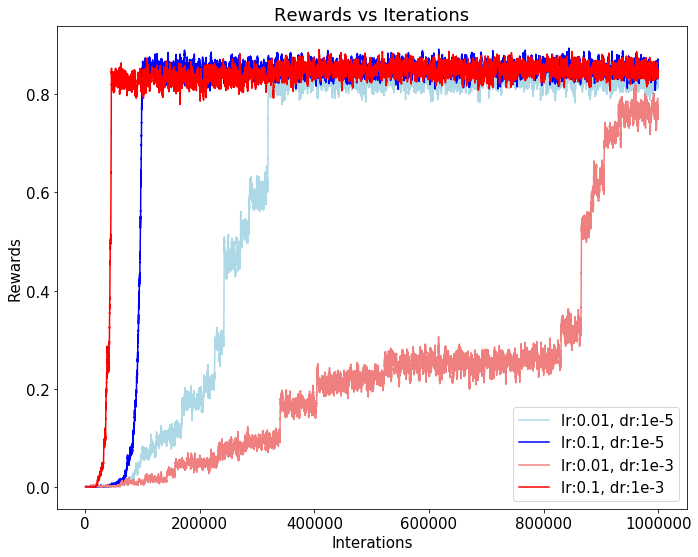

In [138]:
def plot_Q(iterations, rewards_1, rewards_2, rewards_3, rewards_4):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    color = 'black'
    ax1.set_xlabel('Interations')
    ax1.set_ylabel('Rewards')
    ax1.plot(iterations, rewards_1, color="lightblue")
    ax1.plot(iterations, rewards_2, color="blue")
    ax1.plot(iterations, rewards_3, color="lightcoral")
    ax1.plot(iterations, rewards_4, color="red")
    ax1.set_title("Rewards vs Iterations")
    labels = ["lr:0.01, dr:1e-5","lr:0.1, dr:1e-5","lr:0.01, dr:1e-3","lr:0.1, dr:1e-3"]
    ax1.legend(labels)
    fig.tight_layout()  # otherwise the right y-label is sl ightly clipped
    plt.show()

r1 = q_dict_8x8[0.9999][1e6][0.01][1e-5]["rewards"]
r2 = q_dict_8x8[0.9999][1e6][0.1][1e-5]["rewards"]
r3 = q_dict_8x8[0.9999][1e6][0.01][1e-3]["rewards"]
r4 = q_dict_8x8[0.9999][1e6][0.1][1e-3]["rewards"]
run = 1000
rew_running_1 = running_mean(r1, run)
rew_running_2 = running_mean(r2, run)
rew_running_3 = running_mean(r3, run)
rew_running_4 = running_mean(r4, run)
indices = [i+run for i in list(range(len(rew_running_1)))]
plot_Q(indices, rew_running_1, rew_running_2, rew_running_3, rew_running_4)

## 30x30

In [109]:
map_test = fl.generate_random_map(size = 30, p = 0.4)
env_test= fl.FrozenLakeEnv(desc= map_test)

episodes = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]

q_dict_test = train_and_test_q_learning(env_test, discount=[0.9999], total_episodes=episodes,
                          alphas=[0.1, 0.01], decay_rates=decays)

Solved in: 10000.0 episodes and 1.106773853302002 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 1.106773853302002
Mean reward: 0.0 - mean eps: 30.806
Solved in: 10000.0 episodes and 1.180548906326294 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 1.180548906326294
Mean reward: 0.0 - mean eps: 30.186
Solved in: 10000.0 episodes and 1.1386401653289795 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 1.1386401653289795
Mean reward: 0.0 - mean eps: 30.163
Solved in: 10000.0 episodes and 0.9002528190612793 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0.9002528190612793
Mean reward: 0.0 - mean eps: 30.057
Solved in: 100000.0 episodes and 11.72985315322876 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 11.72985315322876
Mean reward: 0.0 - mean eps: 31.695
Solved in: 100000.0 episodes and 11.1079983711

## Comparison plot

In [146]:
epsilon_list_8x8 = [1e-2, 1e-6, 1e-10]
vi_8x8_time = [14.84, 1289.73, 1092.98]
vi_8x8_iteration = [29, 461, 912]
pi_8x8_time = [5.16, 8.2, 6.6]
pi_8x8_iteration = [9, 4, 8]

In [147]:
epsilon_list_30x30 = [1e-4, 1e-8, 1e-12]
vi_30x30_time = [2464, 27728, 32077]
vi_30x30_iteration = [743, 3240, 5508]
pi_30x30_time = [182, 532, 151.7]
pi_30x30_iteration = [36, 36, 6]

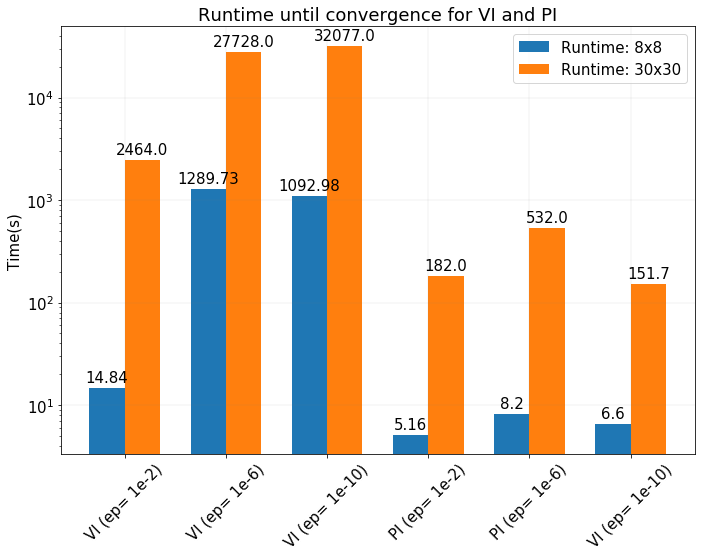

In [153]:
N = 6
labels = ["VI (ep= 1e-2)", "VI (ep= 1e-6)", "VI (ep= 1e-10)", "PI (ep= 1e-2)", "PI (ep= 1e-6)", "VI (ep= 1e-10)"]
algo = np.arange(N) 
width = 0.35      
x = np.arange(len(labels))  # the label locations
time_8x8 = vi_8x8_time + pi_8x8_time
time_30x30 = vi_30x30_time + pi_30x30_time
iteration_8x8 = vi_8x8_iteration + pi_8x8_iteration

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, time_8x8, width, label='Runtime: 8x8')
rects2 = ax.bar(x + width/2, time_30x30, width, label='Runtime: 30x30')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time(s)')
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_title('Runtime until convergence for VI and PI')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(color='gray', linestyle='-', linewidth=0.1)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_yscale('log')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()



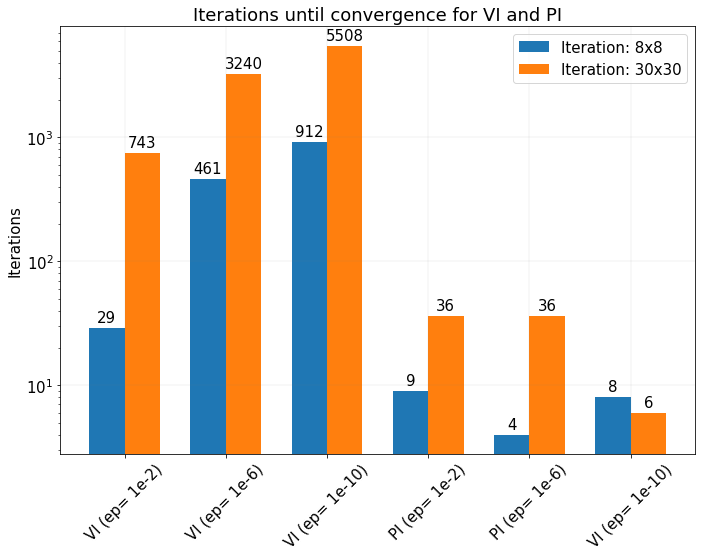

In [154]:
N = 6
labels = ["VI (ep= 1e-2)", "VI (ep= 1e-6)", "VI (ep= 1e-10)", "PI (ep= 1e-2)", "PI (ep= 1e-6)", "VI (ep= 1e-10)"]
algo = np.arange(N) 
width = 0.35      
x = np.arange(len(labels))  # the label locations
time_8x8 = vi_8x8_time + pi_8x8_time
time_30x30 = vi_30x30_time + pi_30x30_time
iteration_8x8 = vi_8x8_iteration + pi_8x8_iteration
iteration_30x30 = vi_30x30_iteration + pi_30x30_iteration

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, iteration_8x8, width, label='Iteration: 8x8')
rects2 = ax.bar(x + width/2, iteration_30x30, width, label='Iteration: 30x30')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Iterations')
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
ax.set_title('Iterations until convergence for VI and PI')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(color='gray', linestyle='-', linewidth=0.1)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_yscale('log')
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

